In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import imp
import sys
sys.path.append('/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi
import seaborn as sns
from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

#### Load functions for validation tools and visualization

In [2]:
%%capture
dist = imp.load_source('*', './validation/dist.py')
matstat = imp.load_source('*', './validation/matrix.py')
testdata = imp.load_source('*', './validation/test_data.py')
vizi = imp.load_source('*', '../INM6/Tasks/viziphant/plots/generic.py')

data_path = '/home/robin/Projects/ValidationTools'
nest_path = data_path + "/sim_data/NEST_data"
spinnaker_path = data_path + "/sim_data/SpiNNaker_data"

# Number of spiketrains:
N = 100

#### Load spiketrains from simulation

In [38]:
spiketrain_list_1 = testdata.load_data(nest_path, ['spikes_L4'], N)[0][0]

spiketrain_list_2 = testdata.load_data(spinnaker_path, ['spikes_L4'], N)[0][0]

#### ...or generate custom spiketrains

In [3]:
spiketrain_list_1 = testdata.test_data(size=N, 
                                       corr=.0, 
                                       t_stop=100000*ms, 
                                       rate=10*Hz, 
                                       assembly_sizes=[],
                                       method="CPP", 
                                       bkgr_corr=0.00,
                                       shuffle_seed=42)

spiketrain_list_2 = testdata.test_data(size=N, 
                                       #corr=.0,
                                       corr=[.5, .5], 
                                       t_stop=100000*ms, 
                                       rate=10*Hz, 
                                       assembly_sizes=[30, 20],
                                       method="CPP", 
                                       bkgr_corr=0.0)#,
                                       #shuffle=False)
                                       #shuffle_seed=42)
for sts in spiketrain_list_2[:10]:
    sts.annotations['assembly']='B'
for sts in spiketrain_list_2[10:15]:
    sts.annotations['assembly']='A'

[ 0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.5]
[ 0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.5]


/usr/local/lib/python2.7/dist-packages/quantities/quantity.py:305: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(other, self)


#### Rasterplots

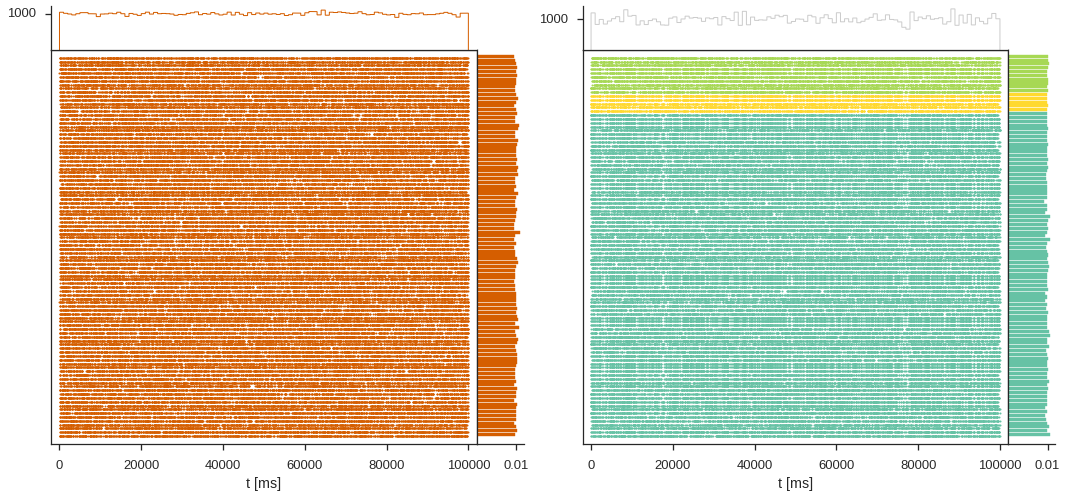

In [114]:
sns.set(style='ticks', palette='Set2', context='talk')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.tight_layout()

assembly_colors = [sns.color_palette()[0], sns.color_palette()[5], sns.color_palette()[4]]

__ = vizi.rasterplot(spiketrain_list_1, ax=ax[0], palette=(['r']), context='talk')
#__ = vizi.rasterplot(spiketrain_list_2, ax=ax[1], palette=[sns.color_palette('Set2')[0]], context='talk', pophist_mode='total')
__ = vizi.rasterplot(spiketrain_list_2, ax=ax[1], palette=assembly_colors, key_list=['assembly'],
                     colorkey='assembly', pophist_mode='total', context='talk')

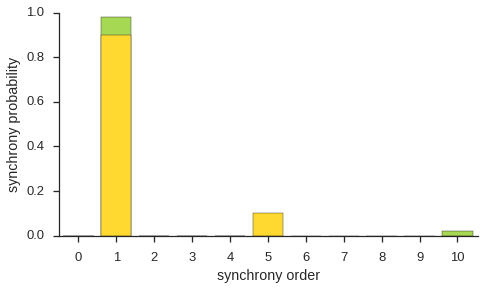

In [115]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5,4))
ax.bar(np.arange(11)-0.4,[0, .98, 0, 0, 0, 0, 0, 0, 0, 0, 0.02], color=sns.color_palette('Set2')[4])
ax.bar(np.arange(6)-0.4,[0, .9, 0, 0, 0, 0.1], color=sns.color_palette('Set2')[5])
# ax.bar([2],[0.05], color=sns.color_palette('Set2')[2], alpha=.5)
ax.set_xlim(-0.5,10.54)
ax.set_ylim(0, 1)
ax.set_xlabel('synchrony order')
ax.set_ylabel('synchrony probability')
ax.set_xticks(np.arange(11))
sns.despine()

### Compare distributions 
##### of CVs, firing rates, correlation coefficients, ...

In [4]:
def func(sts):
    ccs = matstat.corr_matrix(sts,  binsize=2*ms).flatten()  
    # remove autocorrelations
    #ccs[ccs == 1] = 0    
    ccs = np.delete(ccs, np.where(ccs == 1)[0])
    return ccs
    
dist_sample_1 = func(spiketrain_list_1)

dist_sample_2 = func(spiketrain_list_2)

#### Effect Size (Moment Matching)

In [117]:
from numpy import mean, var
from scipy.stats import skew, kurtosis, moment

loggy=False

print "Mean"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=mean, bias_correction=True, 
                 log_scale=loggy)
print "Variance"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=var, bias_correction=True,
                 comparison_args={'ddof':1}, log_scale=loggy)
print "Skewness"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':3}, dof=1, log_scale=loggy)
print "Kurtosis"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':4}, dof=1, log_scale=loggy);
print "Skew Symmetry"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':5}, dof=1, log_scale=loggy);
print "Kurtosis Symmetry"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':6}, dof=1, log_scale=loggy);

Mean

	Effect Size = 0.543 (+- 0.005)
	with 95% probability the true effect size is within [0.537 .. 0.548]

Variance

	Effect Size = 0.452 (+- 0.004)
	with 95% probability the true effect size is within [0.447 .. 0.456]

Skewness

	Effect Size = 0.325 (+- 0.003)
	with 95% probability the true effect size is within [0.321 .. 0.328]

Kurtosis

	Effect Size = 0.280 (+- 0.003)
	with 95% probability the true effect size is within [0.277 .. 0.282]

Skew Symmetry

	Effect Size = 0.234 (+- 0.002)
	with 95% probability the true effect size is within [0.232 .. 0.236]

Kurtosis Symmetry

	Effect Size = 0.197 (+- 0.002)
	with 95% probability the true effect size is within [0.195 .. 0.199]



#### Bayesian Estimation

In [10]:
import best
import best.plot
from pymc import MCMC

drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
101,100,99,101,100,102,99,100,99)

data = {'drug':drug,'placebo':placebo}

model = best.make_model(data)

M = MCMC(model)
M.sample(iter=110000, burn=10000)

best.plot.make_figure(M)

 [-----------------100%-----------------] 110000 of 110000 complete in 11.3 sec

KeyError: 'group1_std'

#### Show Distribution

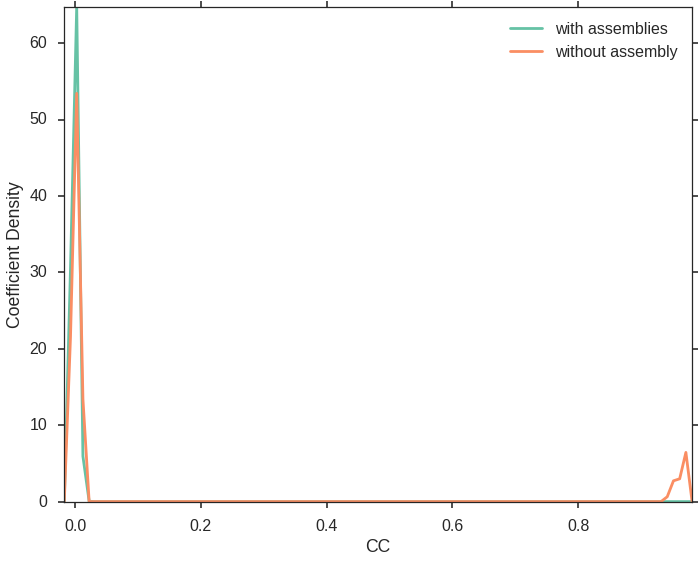

In [118]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
fig.tight_layout()

_ = dist.show(dist_sample_1, dist_sample_2, bins=100, ax=ax)        
ax.legend(['with assemblies', 'without assembly'])
ax.set_ylabel('Coefficient Density')
ax.set_xlabel('CC');
#ax.set_yscale('log')

#### Kullback-Leibler Divergence

$$ D_\mathrm{KL}(P||Q) =\sum_{i} P(i) \log_2 \frac{P(i)}{Q(i)} = H(P,Q) - H(P)$$
$ $

The KL-Divergence is a measure of difference between two distribution based on entropy.

When $P$ can be regarded as reference, $D_\mathrm{KL}$ is the amount of information lost when substituting $Q$ for $P$. Consequently this measure is asymetric.

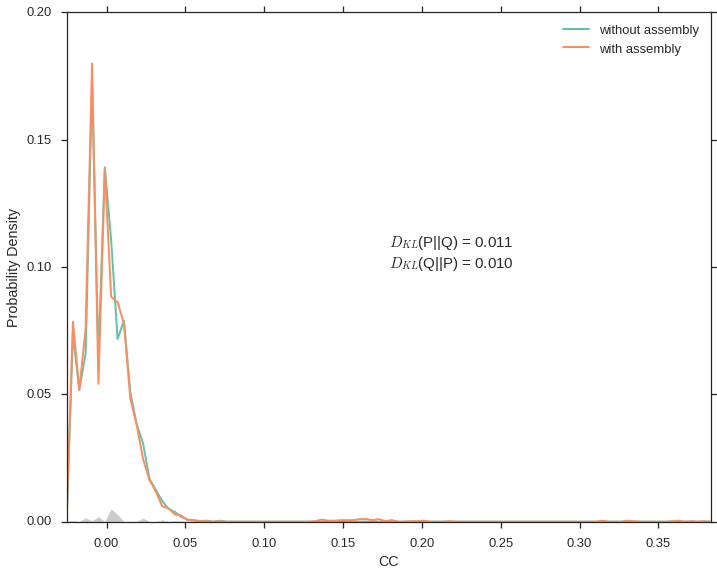

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
fig.tight_layout()

DKL, DKL_inv = dist.KL_test(dist_sample_1, dist_sample_2, ax=ax, bins=100, mute=True, xlabel='CC')
ax.text(.5, .5, r'$D_{KL}$(P||Q) = ' + '{:.3f}\n'.format(DKL) 
                + r'$D_{KL}$(Q||P) = ' + '{:.3f}'.format(DKL_inv), 
        fontsize=15, transform=ax.transAxes)

ax.legend(['without assembly', 'with assembly'])
ax.set_xlabel('CC');

#### Kolmogorov-Smirnov Distance

$$ D_\mathrm{KS} = \sup | \hat{P}(x) - \hat{Q}(x) | $$
$ $

The KS-Distance measures the maximal vertical distance of the cumulative distributions $\hat{P}$ and $\hat{Q}$. This is a sensitive tool for detecting differences in mean, variance or distribution type. But it can't well detect deviations in the tails of the distributions. A possibily more powerful alternative would be the Cramér-von-Mises Test.

$ $

The null hypothesis that the underlying distributions are identical is rejected when the $D_\mathrm{KS}$ statistic is larger than a critical value $D_\alpha$ or equivalently when the correponding p-value is less than the signficance level $\alpha$.


Kolmogorov-Smirnov-Distance
	length 1 = 9900 	 length 2 = 9900
	D_KS = 0.03 	 p value = 1.9e-4



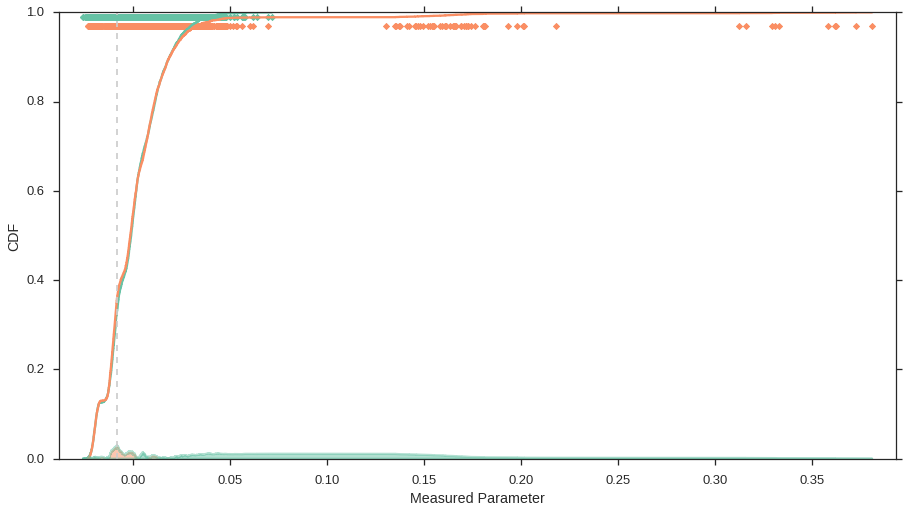

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
DKS, p = dist.KS_test(dist_sample_1, dist_sample_2, ax=ax)

#### Mann-Whitney U Test

$$ U_i = R_i - \frac{n_i(n_i + 1)}{2}\\ U = min(U_1,U_2) $$

$R_i$: rank sum

$n_i$: sample size

$ $

The Mann-Whitney U is a rank statistic which test the null hypothesis that a random value of sample 1 is equally likely to be larger or a smaller value than a randomly chosen value of sample 2.

$ $

The $U_i$ statistic is in the range of $[0,n_1 n_2]$, and the $U=min(U_1,U_2)$ statistic is in the range of $[0,\frac{n_1 n_2}{2}]$.

$ $

For sample sizes $>20$ $U$ follows approximately a normal distribution. With this assumption a p-value can be inferred. The null hypothesis is consequently rejected when the p-value is less than the significance level.


Mann-Whitney-U-Test
	length 1 = 9900 	 length 2 = 9900
	U = 48402294.00   	 p value = 0.13


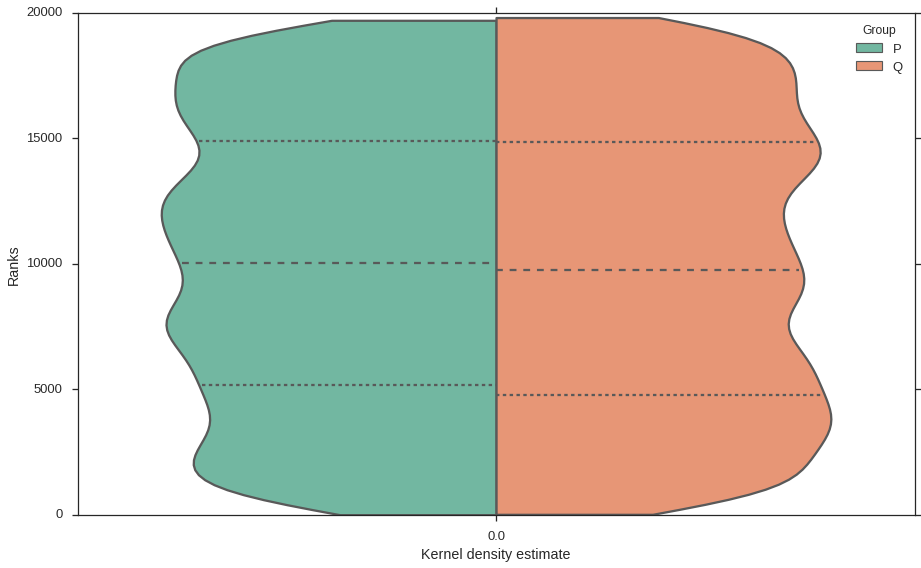

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,9))
U, p = dist.MWU_test(dist_sample_1[:], dist_sample_2[:], ax=ax, excl_nan=True)

### Compare the correlation matrices

#### Heatmap

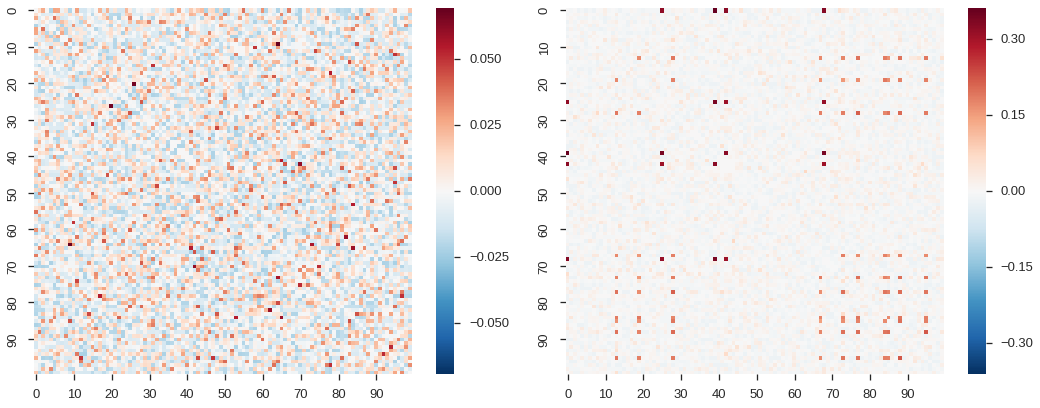

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

corr_matrix_1 = matstat.corr_matrix(spiketrain_list_1)
corr_matrix_2 = matstat.corr_matrix(spiketrain_list_2)

matstat.plot_matrix(corr_matrix_1, ax[0], remove_autocorr=True)
matstat.plot_matrix(corr_matrix_2, ax[1], remove_autocorr=True)

#### Eigenvalue distribution & spectra


Redundancy = 0.03 


Redundancy = 0.01 



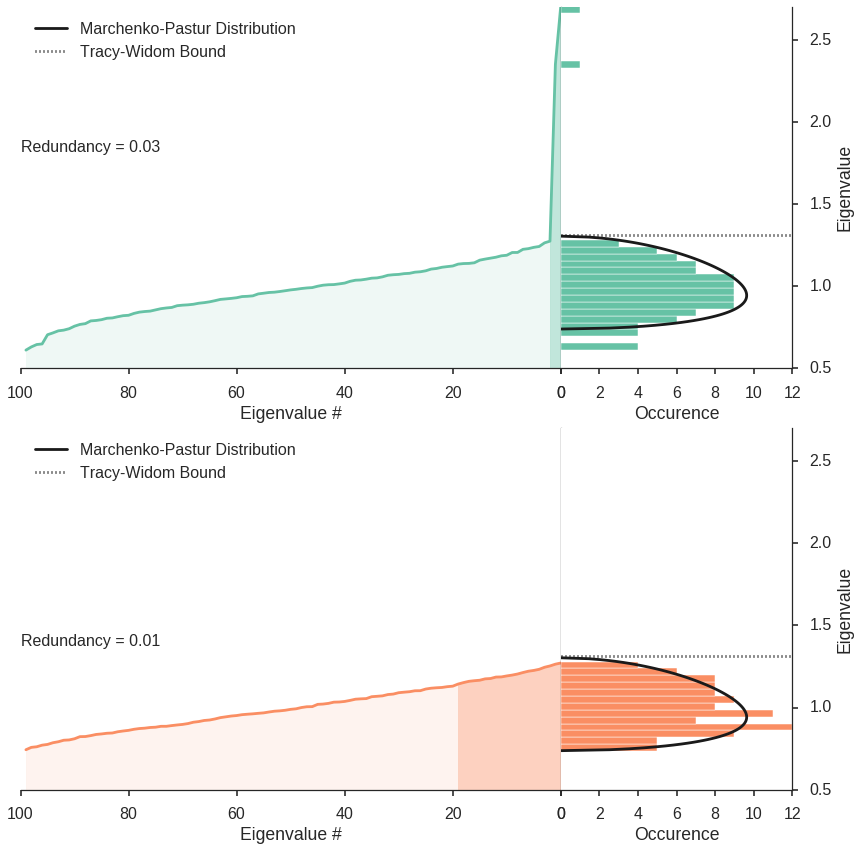

In [74]:
EWs_1, EVs_1 = eigh(corr_matrix_1)
EWs_2, EVs_2 = eigh(corr_matrix_2)

sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,12))
fig.tight_layout()

edges, axhist2 = matstat.eigenvalue_significance(EWs_2, ax[0], bins=50, N=N, B=10000/2, ylim=(0.5,2.7), 
                                     color=sns.color_palette()[0], mute=True)

xmax2 = axhist2.get_xlim()

R2 = matstat.redundancy(EWs_2)
ax[0].text(0, .6, 'Redundancy = ' + '{:.2f}'.format(R2), 
           fontsize=16, transform=ax[0].transAxes)

__, axhist1 = matstat.eigenvalue_significance(EWs_1, ax[1], bins=edges, N=N, B=10000/2, ylim=(0.5,2.7), 
                                     color=sns.color_palette()[1], mute=True)

xmax1 = axhist1.get_xlim()

axhist1.set_xlim((0,max(xmax1[1],xmax2[1])))
axhist2.set_xlim((0,max(xmax1[1],xmax2[1])))

R1 = matstat.redundancy(EWs_1)
ax[1].text(0, .4, 'Redundancy = ' + '{:.2f}'.format(R1), 
           fontsize=16, transform=ax[1].transAxes);

#### Show eigenvectors

In [50]:
if N < 17:
    colormap = [37,37,30,34,32,31,33,36,35] + [47,40,44,42,41,43,46,45]
    matstat.print_eigenvectors(EVs_1, EWs_1, pc_nbr_1, colormap=colormap)
    matstat.print_eigenvectors(EVs_2, EWs_2, pc_nbr_2, colormap=colormap)

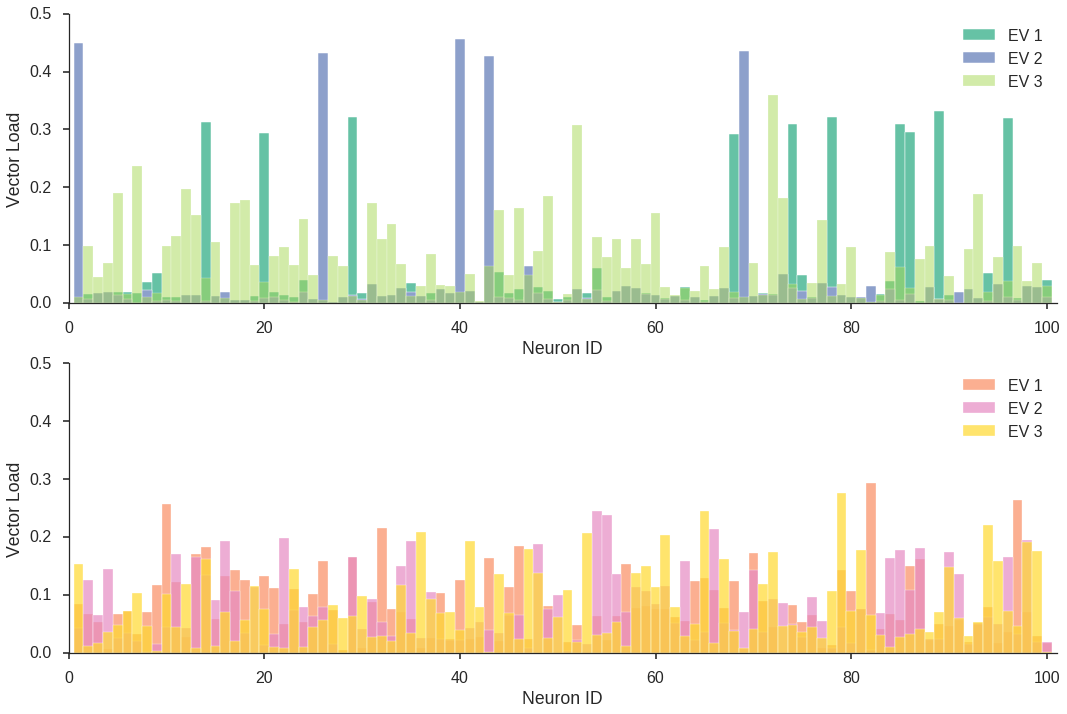

In [75]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
fig.tight_layout()

ax[0].bar(np.arange(100)+.5, np.absolute(EVs_2.T[::-1])[0], 1., edgecolor='w', label='EV 1')
ax[0].bar(np.arange(100)+.5, np.absolute(EVs_2.T[::-1])[1], 1., edgecolor='w', color=sns.color_palette()[2],label='EV 2')
ax[0].bar(np.arange(100)+.5, np.absolute(EVs_2.T[::-1])[2], 1., edgecolor='w', color=sns.color_palette()[4], alpha=.5, 
          label='EV 3')
ax[0].set_xlim(0,101)
ax[0].set_ylim(0,.5)
ax[0].set_xlabel('Neuron ID')
ax[0].set_ylabel('Vector Load')
ax[0].legend()

ax[1].bar(np.arange(100)+.5, np.absolute(EVs_1.T[::-1])[0], 1., edgecolor='w', color=sns.color_palette()[1], alpha=.7,
         label='EV 1')
ax[1].bar(np.arange(100)+.5, np.absolute(EVs_1.T[::-1])[1], 1., edgecolor='w', color=sns.color_palette()[3], alpha=.7,
         label='EV 2')
ax[1].bar(np.arange(100)+.5, np.absolute(EVs_1.T[::-1])[2], 1., edgecolor='w', color=sns.color_palette()[5], alpha=.7,
         label='EV 3')
ax[1].set_xlim(0,101)
ax[1].set_ylim(0,.5)
ax[1].set_xlabel('Neuron ID')
ax[1].set_ylabel('Vector Load')
ax[1].legend()

sns.despine()

#### Angles between eigenspaces

In [52]:
nbr_of_pcs = min(pc_nbr_1, pc_nbr_2)
nbr_of_pcs = 3
_ = matstat.EV_angles(EVs_1[:, -nbr_of_pcs:], EVs_2[:, -nbr_of_pcs:])


Angles between the eigenvectors
	70.17°
	74.83°
	49.98°

Angle between eigenspaces
	89.88°


#### Detect Assemblies

In [53]:
print "\033[36mSample 1\033[0m\n"
__, corr_order_1 = matstat.detect_assemblies(EVs_1, EWs_1, detect_by=.2, EW_lim=1.2, sort=True, jupyter=True)

print "\033[36mSample 2\033[0m\n"
__, corr_order_2 = matstat.detect_assemblies(EVs_2, EWs_2, detect_by=.2, EW_lim=2, sort=True, jupyter=True)

Sample 1

Assembly 1, eigenvalue 1.28, size 5
Neuron ID:	66	60	75	43	89		Norm
Portion:	0.26	0.22	0.21	0.21	0.21		0.50

Assembly 2, eigenvalue 1.26, size 3
Neuron ID:	30	64	93		Norm
Portion:	0.33	0.26	0.22		0.48

Assembly 3, eigenvalue 1.26, size 3
Neuron ID:	54	66	 7		Norm
Portion:	0.25	0.23	0.21		0.40

Assembly 4, eigenvalue 1.25, size 7
Neuron ID:	78	37	52	31	54	 9	29		Norm
Portion:	0.27	0.26	0.23	0.23	0.22	0.21	0.20		0.61

Assembly 5, eigenvalue 1.24, size 1
Neuron ID:	58		Norm
Portion:	0.22		0.22

Assembly 6, eigenvalue 1.23, size 4
Neuron ID:	24	67	18	53		Norm
Portion:	0.33	0.21	0.21	0.21		0.49

Assembly 7, eigenvalue 1.22, size 7
Neuron ID:	74	65	73	40	35	23	14		Norm
Portion:	0.24	0.22	0.21	0.21	0.21	0.21	0.20		0.57

Assembly 8, eigenvalue 1.21, size 3
Neuron ID:	21	44	26		Norm
Portion:	0.23	0.22	0.21		0.39

Assembly 9, eigenvalue 1.21, size 5
Neuron ID:	90	12	50	36	55		Norm
Portion:	0.26	0.25	0.22	0.22	0.20		0.51

Assembly 10, eigenvalue 1.21, size 5
Neuron ID:	91	31	39	61	64		N

#### Show Assemblies in Correlation Matrix

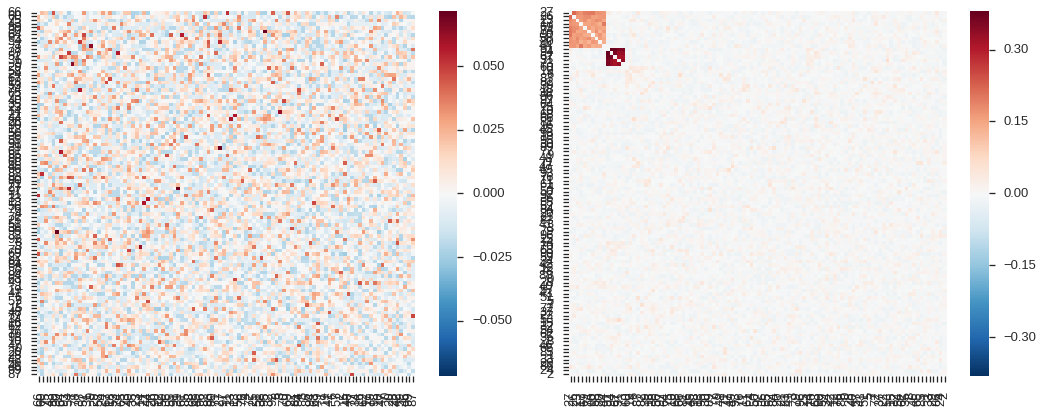

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

ordered_matrix_1 = corr_matrix_1[corr_order_1, :][:, corr_order_1]
ordered_matrix_2 = corr_matrix_2[corr_order_2, :][:, corr_order_2]

matstat.plot_matrix(ordered_matrix_1, ax[0], labels=corr_order_1, remove_autocorr=True)
matstat.plot_matrix(ordered_matrix_2, ax[1], labels=corr_order_2, remove_autocorr=True)